In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [28]:
import torch
import torch.nn as nn
import re
from nltk.corpus import stopwords 
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
data_csv = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(data_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [30]:
x = df['review'].values
y = df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(x,y)
print("number of training examples = ",x_train.size)
print("test data size = ",x_test.size)

number of training examples =  37500
test data size =  12500


In [31]:
def preprocessing(tempStr):
    tempStr = re.sub("[^ 0-9A-Za-z]","",tempStr)
    tempStr = re.sub(r"\s+", '', tempStr) #removing all whitespaces
    tempStr = re.sub(r"[^\w\s]", '', tempStr) #removing all the information which is not a word or number e.g. punctuation marks.
    tempStr = re.sub(r"\d", '', tempStr) #removing all the digits also
    return tempStr

In [32]:

def getNonStopWordList():
	tobe = [] #list to contain all the words which has less weights e.g. - to,for,the etc.
	StopWords = set(stopwords.words('english'))
	for review in x_train:
		for word in review.lower().split():
			word = preprocessing(word)
			if word != '' and word not in StopWords:
				tobe.append(word)
	return tobe

In [33]:
def create_tokens():
    nonStopWordList = getNonStopWordList()
    frequency = Counter(nonStopWordList)
    sortedDescByFreq = sorted(frequency,key=frequency.get,reverse=True)[:1000] #sorting by freq in descending order
    vocabulary = {word:_+1 for _,word in enumerate(sortedDescByFreq)} #used for vocabulary
    
    trainArr,testArr = [],[]
    for review in x_train:
        templist = []
        for word in review.lower().split():
            if preprocessing(word) in vocabulary.keys():
                templist.append(vocabulary[preprocessing(word)])
        trainArr.append(templist)
                                     
    for review in x_test:
        templist = []
        for word in review.lower().split():
            if preprocessing(word) in vocabulary.keys():
                templist.append(vocabulary[preprocessing(word)])
        testArr.append(templist)
                                    
    trEnc,teEnc = [],[] #contains the encoded values.
    for sentiments in y_train:
        trEnc.append(int(sentiments=="positive"))

    for sentiments in y_test:
        teEnc.append(int(sentiments=="positive"))

    return np.array(trainArr), np.array(trEnc),np.array(testArr), np.array(teEnc),vocabulary

In [34]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(37500,) (37500,) (12500,) (12500,)


In [35]:
# x_train

In [36]:
x_train,y_train,x_test,y_test,vocab = create_tokens()

In [37]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(37500,) (37500,) (12500,) (12500,)


In [38]:
print(vocab)

{'br': 1, 'movie': 2, 'film': 3, 'one': 4, 'like': 5, 'good': 6, 'even': 7, 'would': 8, 'time': 9, 'really': 10, 'see': 11, 'story': 12, 'well': 13, 'much': 14, 'get': 15, 'also': 16, 'great': 17, 'bad': 18, 'people': 19, 'first': 20, 'dont': 21, 'make': 22, 'movies': 23, 'made': 24, 'films': 25, 'could': 26, 'way': 27, 'characters': 28, 'think': 29, 'watch': 30, 'many': 31, 'seen': 32, 'character': 33, 'two': 34, 'never': 35, 'love': 36, 'acting': 37, 'plot': 38, 'best': 39, 'little': 40, 'know': 41, 'show': 42, 'life': 43, 'ever': 44, 'better': 45, 'still': 46, 'scene': 47, 'say': 48, 'end': 49, 'man': 50, 'scenes': 51, 'something': 52, 'go': 53, 'im': 54, 'back': 55, 'real': 56, 'thing': 57, 'watching': 58, 'doesnt': 59, 'actors': 60, 'didnt': 61, 'years': 62, 'another': 63, 'actually': 64, 'though': 65, 'funny': 66, 'makes': 67, 'find': 68, 'nothing': 69, 'look': 70, 'going': 71, 'work': 72, 'new': 73, 'lot': 74, 'every': 75, 'old': 76, 'part': 77, 'us': 78, 'director': 79, 'cant':

mean review length =  69.35090666666666
minimum review length =  654


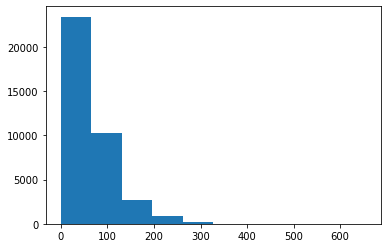

In [39]:
#we will try to analyze our data and if possible try to manually remove some unnecessary informations
reviewSize = []
for review in x_train:
    reviewSize.append(len(review))

reviewSize = np.array(reviewSize)
plt.hist(reviewSize)
print("mean review length = ",np.mean(reviewSize))
print("minimum review length = ",np.amax(reviewSize))

In [40]:
def create2D(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for _, review in enumerate(sentences):
        if len(review) != 0:
            features[_, -len(review):] = np.array(review)[:seq_len]
    return features

In [41]:
x_train_padded = create2D(x_train,350)
x_test_padded = create2D(x_test,350)

In [42]:
# create Tensor datasets
train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train_padded), torch.from_numpy(y_train))
valid_data = torch.utils.data.TensorDataset(torch.from_numpy(x_test_padded), torch.from_numpy(y_test))

# dataloaders
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=50)
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=50)

In [43]:
# obtain one batch of training data
iterator = iter(train_loader)
batch1_x, batch1_y = iterator.next()

In [44]:
class LSTM(nn.Module):
    def __init__(self,layersCount,vocabLen,hiddenDim,embeddingDim,dropoutProb=0.5):
        super(LSTM,self).__init__()
        self.no_layers = layersCount
        self.hidden_dim = hiddenDim 
        self.output_dim = 1
        self.vocab_size = vocabLen
    
        # embedding
        self.embedding = nn.Embedding(vocabLen, embeddingDim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embeddingDim,hidden_size=self.hidden_dim,num_layers=layersCount, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.5)
    
        # linear layer
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        
        #sigmoid layer
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        lstm_output, hidden = self.lstm(self.embedding(x), hidden)    
        lstm_out = lstm_output.contiguous().view(-1, self.hidden_dim) 
        
        # calculating and sigmoid function and reshaping
        sig_output = self.sig(self.fc(self.dropout(lstm_out))).view(batch_size, -1)
        sig_output = sig_output[:, -1] # getting the last batch
        
        # return last sigmoid output and hidden state
        return sig_output, hidden
        
        
        
    def get_hidden(self, batch_size):
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [45]:
batch_size,layersCount,vocabLen,embeddingDim,hiddenDim = 50,2,len(vocab)+1,64,250
model = LSTM(layersCount,vocabLen,embeddingDim,hiddenDim)

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
# loss and optimization functions
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay = 1e-4)

# function to predict accuracy
def acc(pred,act):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == act.squeeze()).item()

In [48]:
 torch.cuda.empty_cache()

In [49]:
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
model = model.to(device)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=2,
                                                   gamma=0.1)
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.get_hidden(batch_size)
#     h.to(device)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs, labels 
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
 
    
    lr_scheduler.step()   
    val_h = model.get_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs, labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.4474129702647527 val_loss : 0.36699270391464234
train_accuracy : 79.16266666666667 val_accuracy : 84.296
Validation loss decreased (inf --> 0.366993).  Saving model ...
Epoch 2
train_loss : 0.3458166791995366 val_loss : 0.4388983317017555
train_accuracy : 85.46133333333333 val_accuracy : 81.64
Epoch 3
train_loss : 0.29270732633272806 val_loss : 0.33358080172538757
train_accuracy : 87.95733333333334 val_accuracy : 85.576
Validation loss decreased (0.366993 --> 0.333581).  Saving model ...
Epoch 4
train_loss : 0.2802079609334469 val_loss : 0.3311051280498505
train_accuracy : 88.56533333333333 val_accuracy : 85.816
Validation loss decreased (0.333581 --> 0.331105).  Saving model ...
Epoch 5
train_loss : 0.2702257093886534 val_loss : 0.3311244160532951
train_accuracy : 88.97066666666666 val_accuracy : 85.848
Epoch 6
train_loss : 0.26999389845132826 val_loss : 0.3305479584634304
train_accuracy : 89.00266666666667 val_accuracy : 85.84
Validation loss decreased (0.33110

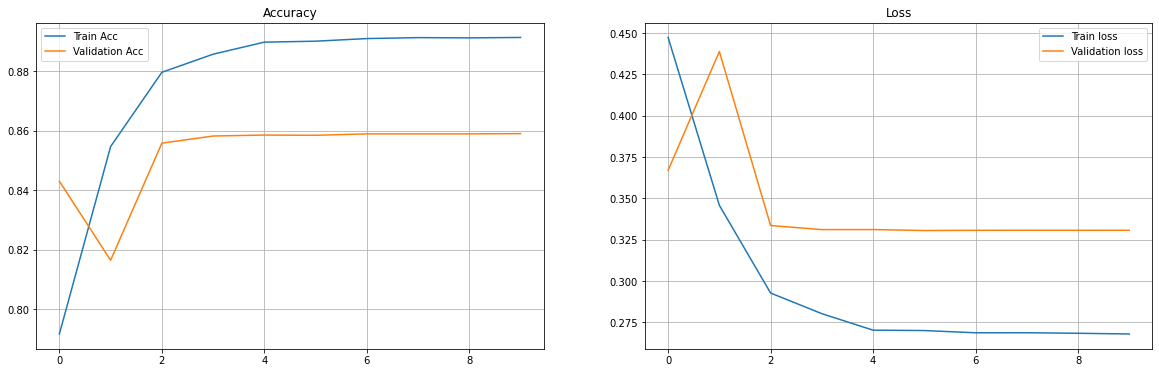

In [50]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [51]:
def predict_text(text):
    word_seq = np.array([vocab[preprocessing(word)] for word in text.split() 
                     if preprocessing(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(create2D(word_seq,500))
    inputs = pad.to(device)
    batch_size = 1
    h = model.get_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    return(output.item())

In [52]:

index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {str(df["sentiment"][index])}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {str(status)} with a probability of {str(pro)}')

Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve

In [53]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

My first exposure to the Templarios & not a good one. I was excited to find this title among the offerings from Anchor Bay Video, which has brought us other cult classics such as "Spider Baby". The print quality is excellent, but this alone can't hide the fact that the film is deadly dull. There's a thrilling opening sequence in which the villagers exact a terrible revenge on the Templars (& set the whole thing in motion), but everything else in the movie is slow, ponderous &, ultimately, unfulfilling. Adding insult to injury: the movie was dubbed, not subtitled, as promised on the video jacket.
Actual sentiment is  : negative
predicted sentiment is negative with a probability of 0.9523466043174267
